#Practico TP6 (Convolución)

Implementar un aplicativo que levante una imagen en nivel de gris (o que la convierta a YIQ y retenga solo el Y) y aplique el filtrado por convolución para los siguientes filtros:
1. Pasabajos: Plano y Bartlett 3x3, 5x5, 7x7. Gaussiano 5x5 y 7x7.
2. Detectores de bordes: Laplaciano v4 y v8. Sobel las 8 orientaciones.
3. Pasabanda, pasaaltos de frecuencia de corte 0,2 y 0,4

Respecto del “cierre” de la imagen cerca de los bordes, implementar la técnica no matemáticamente perfecta de “repetir” artificialmente filas o columnas cuando estas hagan falta. Por ejemplo, si el kernel es 3x3 y estoy en la primera columna, y no hay ninguna columna a la izquierda, entonces repito la primera columna como si estuviese en la imagen original. Otra opción es la conocida como padding en la cual adicionamos filas y columnas de ceros en los extremos de la imagen, similar al que les mostré para hacer que dos imágenes tengan el mismo tamaño.

Deben mostrar el aplicativo que permita cargar o seleccionar la imagen y elegir de una lista el filtro a aplicar ver su resultado. Adicionalmente deben mostrar un plot con todos los filtros aplicados para la imagen de entrada.

In [2]:
import numpy as np
import imageio
from matplotlib import pyplot as plt

#FOURIER TRANSFORM
def FT_spectrum(img):
  dims = img.shape
  if (len(dims) > 2):
    img_ft = np.fft.fftshift(np.fft.fft2(np.clip(img[:, :, 0] / 255., 0., 1.)))
  else:
    img_ft = np.fft.fftshift(np.fft.fft2(np.clip(img / 255., 0., 1.)))
  
  return np.uint8(np.floor(np.log(np.abs(img_ft) + 1.))), np.angle(img_ft) #ABSOLUTE VALUE, PHASE

def IFT_image(ft_img_abs, ft_img_phase):
  rebuilt_img = (np.power(np.e, ft_img_abs) - 1) * (np.cos(ft_img_phase) + np.sin(ft_img_phase) * 1j)
  return np.abs(np.fft.ifft2(np.fft.ifftshift(rebuilt_img)))

<Figure size 432x288 with 0 Axes>

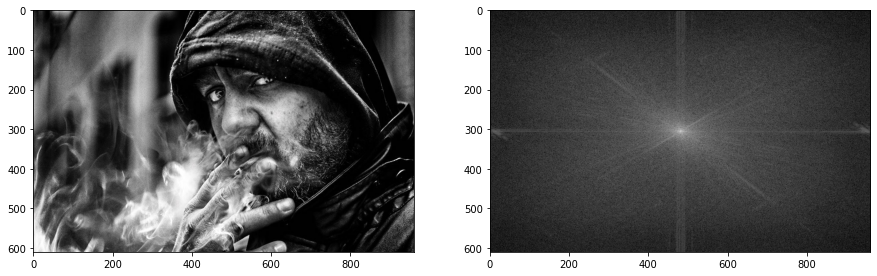

In [18]:
#LITTLE GIRL FOR BLURRING
#URL = 'https://th.bing.com/th/id/R.747a6a1b7ebc3f0afe11fe7659036fda?rik=xFrw2miXoua07w&riu=http%3a%2f%2fgrubbasoftware.com%2fgfx%2fnoise-counter-example2.jpg&ehk=Qfl5oRFs5c%2fqEhitFMCYxDX4iWqJniLUomrSLjs1nuw%3d&risl=&pid=ImgRaw&r=0'

#SILHOUETTE FOR BLURRING
#URL = 'https://www.shutterstock.com/blog/wp-content/uploads/sites/5/2018/05/3-14.jpg'

#LEMUR FOR ENHANCEMENT FILTERS
#URL = 'https://i.pinimg.com/originals/8a/28/bd/8a28bd959cda8a0fc956866453f36e58.jpg'

#MAN SMOKING FOR EDGE DETECTION
URL = 'https://th.bing.com/th/id/R.9cb7d72f86d80c2a828b24fae4b5e10c?rik=Pn8k1bNk8MNvkQ&riu=http%3a%2f%2fwww.fubiz.net%2fwp-content%2fuploads%2f2014%2f12%2fDark-Portraits-Photography_2.jpg&ehk=Rech7Me5y2wRVeOSxVYZNlJ1rkxG3Hc6LyLGToeecAI%3d&risl=&pid=ImgRaw&r=0'

img = imageio.imread(URL)

#PLOTTING
plt.set_cmap('gray')
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
img_ft_abs, img_ft_phase = FT_spectrum(img)
ax[0].imshow(img)
ax[1].imshow(img_ft_abs)
plt.show()

##Filtro Pasabajo

In [4]:
#EXPAND EDGES BY PADDLING
def expand_edges(img, n):
    dim = img.shape
    new_img = np.zeros((dim[0] + 2 * n, dim[1] + 2 * n))
    if (len(dim) > 2):
      new_img[n:-n, n:-n] = img[:, :, 0]
    else:
      new_img[n:-n, n:-n] = img
    return new_img

def low_pass_filtering(img, filter_type, filter_ize):
  #FILTER GENERATION
  n = 0
  if filter_size == '3x3':
    n = 1
  elif filter_size == '5x5':
    n = 2
  elif filter_size == '7x7':
    n = 3
  
  filter_mask = None
  A = None
  if filter_type == 'Plano':
    A = np.ones(2 * n + 1)
  elif filter_type == 'Bartlett':
    if n == 1:
      A = np.array([1, 2, 1])
    elif n == 2:
      A = np.array([1, 2, 3, 2, 1])
    elif n == 3:
      A = np.array([1, 2, 3, 4, 3, 2, 1])
  elif filter_type == 'Gaussiano':
    if n == 1:
      A = np.array([1, 2, 1])
    elif n == 2:
      A = np.array([1, 4, 6, 4, 1])
    elif n == 3:
      A = np.array([1, 6, 15, 20, 15, 6, 1])
  
  filter_mask = np.outer(A, A)
  filter_mask = filter_mask / np.sum(filter_mask)
  #CONVOLUTION
  expanded_img = expand_edges(img, n) / 255
  new_img = np.zeros(img.shape)
  for (i, j), v in np.ndenumerate(expanded_img[n:-n, n:-n]):
    new_img[i, j] = np.sum(expanded_img[i : i + (2 * n + 1), j : j + (2 * n + 1)] * filter_mask)
  
  return np.uint8(np.clip(new_img * 255, 0, 255))

In [5]:
def low_pass_ft_filtering(img, filter_type, filter_size):
  img_size = img.shape
  if len(img_size) > 2:
    img_size = (img_size[0], img_size[1])
  center = (np.int(np.floor(img_size[0] // 2)), np.int(np.floor(img_size[1] // 2)))
  max_size = np.max([img_size[0] - 1, img_size[1] - 1])
  img_ft_abs, img_ft_phase = FT_spectrum(img)
  img_ft_abs = img_ft_abs / max_size
  #FILTER GENERATION
  n = 0
  if filter_size == '3x3':
    n = 1
  elif filter_size == '5x5':
    n = 2
  elif filter_size == '7x7':
    n = 3
  
  filter_mask = None
  A = None
  if filter_type == 'Plano':
    A = np.ones(2 * n + 1)
  elif filter_type == 'Bartlett':
    if n == 1:
      A = np.array([1, 2, 1])
    elif n == 2:
      A = np.array([1, 2, 3, 2, 1])
    elif n == 3:
      A = np.array([1, 2, 3, 4, 3, 2, 1])
  elif filter_type == 'Gaussiano':
    if n == 1:
      A = np.array([1, 2, 1])
    elif n == 2:
      A = np.array([1, 4, 6, 4, 1])
    elif n == 3:
      A = np.array([1, 6, 15, 20, 15, 6, 1])
  
  filter_mask = np.zeros(img_size)
  outer_prod = np.outer(A, A)
  filter_mask[center[0] - n : center[0] + n + 1, center[1] - n : center[1] + n + 1] = outer_prod * 255 / np.max(outer_prod)
  
  #FOURIER CONVOLUTION
  filter_ft_abs, filter_ft_phase = FT_spectrum(filter_mask)
  filter_ft_abs = filter_ft_abs / max_size
  #plt.imshow(filter_ft_abs)
  return IFT_image(img_ft_abs * filter_ft_abs * max_size**2, img_ft_phase)


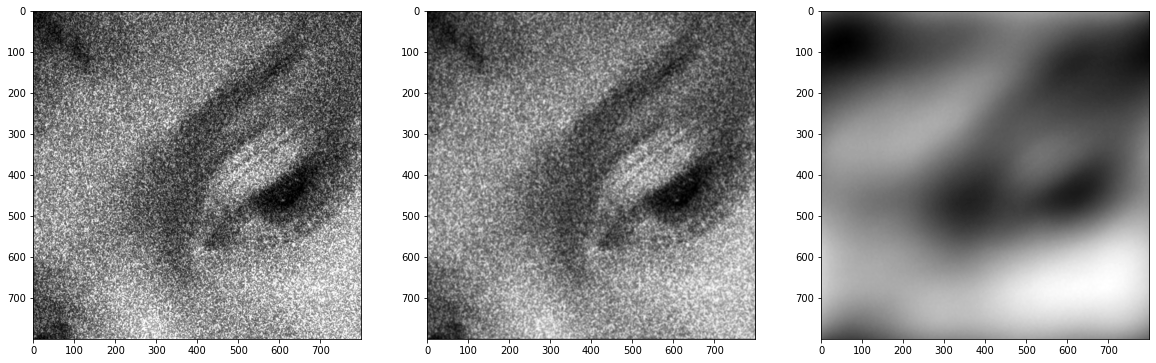

In [ ]:
#@title Pick a filter {run:"auto"}

filter_type = 'Gaussiano' #@param ['Plano', 'Bartlett', 'Gaussiano']
filter_size = '7x7' #@param ['3x3', '5x5', '7x7']

new_img = low_pass_filtering(img, filter_type, filter_size)
new_img_ft = low_pass_ft_filtering(img, filter_type, filter_size)
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(img)
ax[1].imshow(new_img)
ax[2].imshow(new_img_ft)
plt.show()

##Detector de Bordes

In [15]:
def edge_detecting(img, filter_type):
  n = 1
  #FILTER GENERATION
  filter_mask = np.zeros((3, 3))
  if filter_type == 'Laplaciano v4':
    filter_mask = np.array([[ 0, -1,  0], 
                            [-1,  4, -1], 
                            [ 0, -1,  0]])
  elif filter_type == 'Laplaciano v8':
    filter_mask = np.array([[-1, -1, -1], 
                            [-1,  8, -1], 
                            [-1, -1, -1]])
  elif filter_type == 'Sobel (izquierda derecha)':
    filter_mask = np.array([[-1, 0, 1], 
                            [-2, 0, 2], 
                            [-1, 0, 1]])
  elif filter_type == 'Sobel (derecha izquierda)':
    filter_mask = np.array([[1, 0, -1], 
                            [2, 0, -2], 
                            [1, 0, -1]])
  elif filter_type == 'Sobel (abajo arriba)':
    filter_mask = np.array([[ 1,  2,  1], 
                            [ 0,  0,  0], 
                            [-1, -2, -1]])
  elif filter_type == 'Sobel (arriba abajo)':
    filter_mask = np.array([[-1, -2, -1], 
                            [ 0,  0,  0], 
                            [ 1,  2,  1]])
  elif filter_type == 'Sobel (noreste suroeste)':
    filter_mask = np.array([[-2, -1, 0], 
                            [-1,  0, 1], 
                            [ 0,  1, 2]])
  elif filter_type == 'Sobel (suroeste noreste)':
    filter_mask = np.array([[2,  1,  0], 
                            [1,  0, -1], 
                            [0, -1, -2]])
  elif filter_type == 'Sobel (sureste noroeste)':
    filter_mask = np.array([[ 0,  1,  2], 
                            [-1,  0,  1], 
                            [-2, -1,  0]])
  elif filter_type == 'Sobel (noroeste sureste)':
    filter_mask = np.array([[ 0, -1, -2], 
                            [ 1,  0, -1], 
                            [ 2,  1,  0]])
  
  #CONVOLUTION
  expanded_img = expand_edges(img, n) / 255
  new_img = np.zeros(img.shape)
  for (i, j), v in np.ndenumerate(expanded_img[n:-n, n:-n]):
    new_img[i, j] = np.sum(expanded_img[i : i + (2 * n + 1), j : j + (2 * n + 1)] * filter_mask)
  
  return np.uint8(np.clip(new_img * 255, 0, 255))

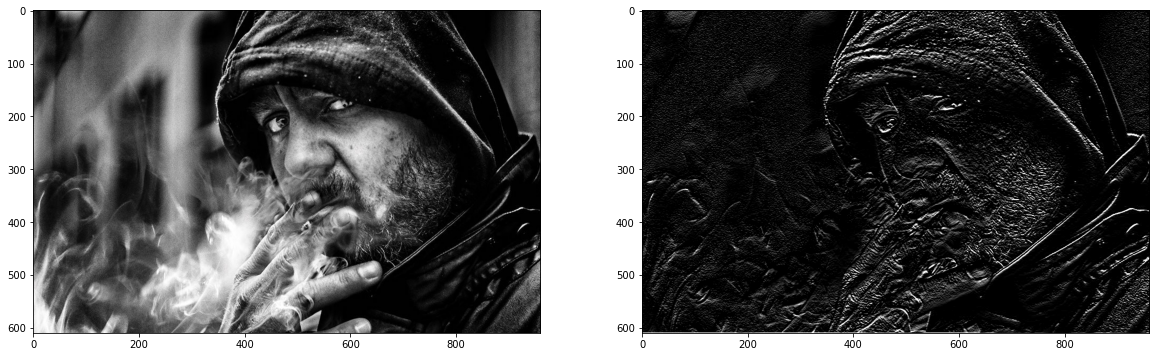

In [19]:
#@title Pick a filter {run:"auto"}

filter_type = 'Sobel (abajo arriba)' #@param ['Laplaciano v4', 'Laplaciano v8', 'Sobel (izquierda derecha)', 'Sobel (derecha izquierda)', 'Sobel (arriba abajo)', 'Sobel (abajo arriba)', 'Sobel (noreste suroeste)', 'Sobel (suroeste noreste)', 'Sobel (sureste noroeste)', 'Sobel (noroeste sureste)', 'DOG']

new_img = edge_detecting(img, filter_type)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img)
ax[1].imshow(new_img)
#ax[2].imshow(new_img_ft)
plt.show()

##Filtros de realce

In [11]:
def enhancement(img, filter_type):
  n = 1
  #FILTER GENERATION
  filter_mask = np.array([[ 0., -1.,  0.], 
                          [-1.,  4., -1.], 
                          [ 0., -1.,  0.]])
  
  if filter_type == 'Realce 0.2':
    filter_mask += np.ones((3, 3)) * 0.2
  elif filter_type == 'Realce 0.4':
    filter_mask += np.ones((3, 3)) * 0.4
  
  #CONVOLUTION
  expanded_img = expand_edges(img, n) / 255
  new_img = np.zeros(img.shape)
  for (i, j), v in np.ndenumerate(expanded_img[n:-n, n:-n]):
    new_img[i, j] = np.sum(expanded_img[i : i + (2 * n + 1), j : j + (2 * n + 1)] * filter_mask)
  
  return np.uint8(np.clip(new_img * 255, 0, 255))

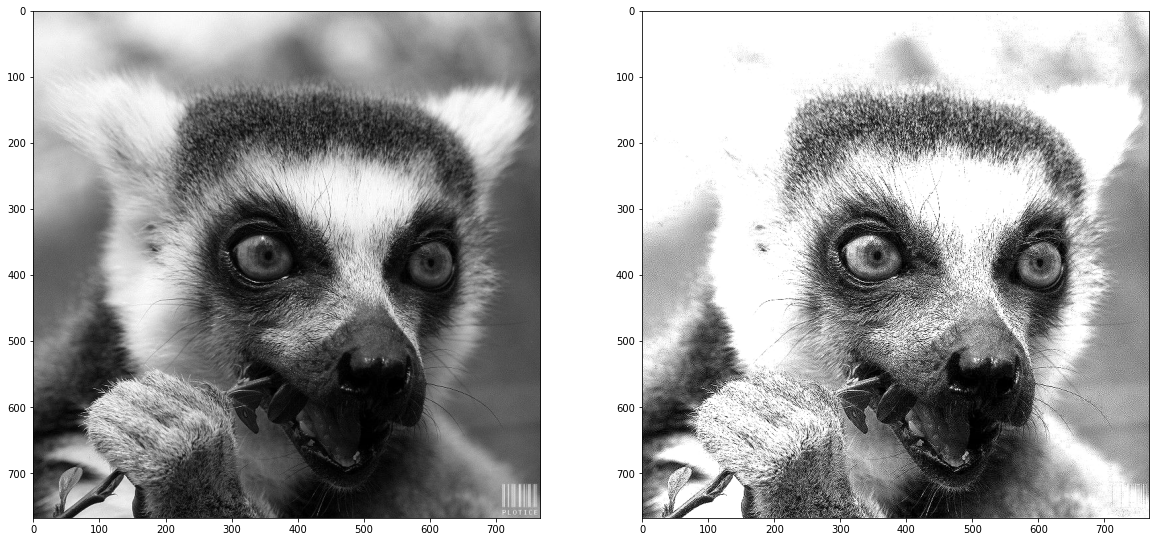

In [14]:
#@title Pick a filter {run:"auto"}

filter_type = 'Realce 0.2' #@param ['Realce 0.2', 'Realce 0.4']

new_img = enhancement(img, filter_type)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img)
ax[1].imshow(new_img)
#ax[2].imshow(new_img_ft)
plt.show()